# YOLOV2 - Tensorflow 2.0

## Import all necessary libraries

In [ ]:
# Colab need to install
#!pip install --upgrade pip

#!pip install tensorflow
#!pip install tensorflow-gpu

In [1]:
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, \
                                    MaxPooling2D, BatchNormalization, \
                                    Flatten, Dense, Lambda, LeakyReLU, \
                                    concatenate
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

%matplotlib inline

print(tf.__version__)
print(tf.keras.__version__)

2.0.0
2.2.4-tf


## Colab

In [ ]:
#確認GPU運行正常
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
from google.colab import drive, files

# 指定google drive雲端硬碟盤的根目錄，名為drive
drive.mount('/content/drive')
!mkdir -p drive

'''
#上傳檔案到colab
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
'''

In [ ]:
import os

#此處為google drive中的文件路徑,drive為之前指定的工作跟目錄，
path = "/content/drive/My Drive/test/yolov2-tf2"
os.chdir(path)

!ls

## Load Data

- [kangaroo](https://github.com/kaka-lin/kangaroo) dataset:
    A dataset of 183 images and annotations for kangaroo detection. 
    `PASCAL VOC's XML format`
    
#### [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/)

    - Image: 存放訓練和測試圖面
    - Annatations: XML格式的標籤檔案，每個XML檔案都對應於Image資料夾的一張圖片

### Load the tf.data.Dataset from TFRecord files

In [2]:
# load data from Google drive
#raw_train_dataset = tf.data.TFRecordDataset(path + '/data/train_voc.tfrecord')

# load data from local
raw_train_dataset = tf.data.TFRecordDataset('./data/train_voc.tfrecord')

raw_train_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

## Explore the dataset

### 1. Parse VOC dataset

In [ ]:
for raw_train_data in raw_train_dataset.take(1):    
    example = tf.train.Example()
    example.ParseFromString(raw_train_data.numpy())  
    print(example)

In [3]:
# Create a dictionary describing the features.
image_feature_description = {
    'filename': tf.io.FixedLenFeature([], tf.string),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'classes': tf.io.VarLenFeature(tf.int64),
    'x_mins': tf.io.VarLenFeature(tf.float32),
    'y_mins': tf.io.VarLenFeature(tf.float32),
    'x_maxes': tf.io.VarLenFeature(tf.float32),
    'y_maxes': tf.io.VarLenFeature(tf.float32),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def parse_tf_example(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.io.parse_single_example(example_proto, image_feature_description)
    
    x_train = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)
    #x_train = tf.image.resize(x_train, (416, 416)) # yolov2 - input size
    #x_train /= 255.
    
    width = tf.cast(parsed_example['width'], tf.float32)
    height = tf.cast(parsed_example['height'], tf.float32)
    
    labels = tf.sparse.to_dense(parsed_example['classes'])
    labels = tf.cast(labels, tf.float32)
    
    xmin = tf.sparse.to_dense(parsed_example['x_mins'])
    ymin = tf.sparse.to_dense(parsed_example['y_mins'])
    xmax = tf.sparse.to_dense(parsed_example['x_maxes'])
    ymax = tf.sparse.to_dense(parsed_example['y_maxes'])
    
    y_train = tf.stack([xmin,ymin,
                        xmax,ymax,
                        labels], axis=1)
    
    return x_train, y_train

train_dataset = raw_train_dataset.map(parse_tf_example)
train_dataset

<MapDataset shapes: ((None, None, 3), (None, 5)), types: (tf.uint8, tf.float32)>

### 2. Show the data

- (xmin, ymin, xmax, ymax): already normalization to 0~1.

tf.Tensor(
[[0.5177778  0.27899686 0.8577778  0.8213166  0.        ]
 [0.29777777 0.3291536  0.75777775 0.79310346 0.        ]], shape=(2, 5), dtype=float32)


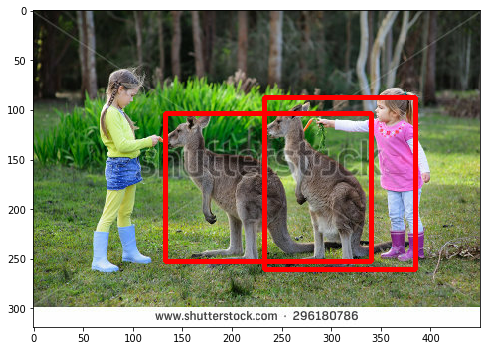

In [4]:
for i, (x, y) in enumerate(train_dataset.take(1)):
    print(y)
    
    img = x.numpy()
    boxes = y.numpy()
    
    height, width = tf.shape(img)[0].numpy(), tf.shape(img)[1].numpy()
    
    for box in boxes:
        left = (box[0] * width).astype('int32')
        top = (box[1] * height).astype('int32')
        right = (box[2] * width).astype('int32')
        bottom = (box[3] * height).astype('int32')
    
        # cv2.rectangle(image, (left, top), (right, bottom), color, thickness)
        cv2.rectangle(img, (left, top), (right, bottom), (255, 0, 0), 3)
    
    f, (ax1) = plt.subplots(1, 1, figsize=(8,8))
    f.subplots_adjust(hspace = .2, wspace = .05)
    
    ax1.imshow(img)
    #ax1.set_title('{}'.format(filename), fontsize=20)
    

## YOLOv2 Model's setting and parameter. 

In [5]:
# anchor boxes
#YOLO_ANCHORS = np.array(
#    [(0.57273, 0.677385), (1.87446, 2.06253), (3.33843, 5.47434),
#     (7.88282, 3.52778), (9.77052, 9.16828)], np.float32)

# For kangaroo dataset
YOLO_ANCHORS = np.array(
    [(9.42263202, 9.18164528), (2.04368121, 2.28255682), (5.80786578, 5.43905892), 
     (2.95958038, 7.13051561), (5.3929678 ,9.97381383)], np.float32)

YOLO_ANCHORS /= 13

# loss
object_scale = 5.0
no_object_scale = 1.0
class_scale = 1.0
coordinates_scale = 1.0

num_max_box = 50

## Preprocess the dataset

- images: resize to (416, 416)
- labels: `(xmin, ymi, xmax, ymax, class)` -> `(num_max_boxes, (x_center, y_center, w, h, class))`

- max ture boxes: 50

In [6]:
def transform_bboxes_for_output(true_boxes, anchors, image_size=416):
    grid_size = image_size // 32

    """Area of anchor."""
    # anchors shape: (5, 2)
    # Note: normalization anchors to 0~1 (anchors / 13)
    #       -> anchors and boxes_wh are moved to origin point
    #       -> we can conveniently find the minimum 
    #          between anchors and boxes_wh to find the intersection area.
    anchor_area = anchors[..., 0] * anchors[..., 1] # (5,)
    
    """ Area of boxes."""
    # true_boxes shape: (num_boxes, (x, y, w, h, classes))
    boxes = tf.reshape(true_boxes, [-1, 5])
    boxes_xy = boxes[..., 0:2]
    boxes_wh = boxes[..., 2:4] # (N, 2)
    
    # expand dimension for compare with anchor
    boxes_wh = tf.tile(tf.expand_dims(boxes_wh, -2),
                     (1, tf.shape(anchors)[0], 1)) # (N, 5, 2)
    boxes_area = boxes_wh[..., 0] * boxes_wh[..., 1] # (N, 5)
    
    """Find IOU between box shifted to origin and anchor box."""
    intersection_wh = tf.minimum(boxes_wh, anchors) # (N, 5, 2)
    intersection_area = intersection_wh[..., 0] * intersection_wh[..., 1] # (N, 5)
    iou = intersection_area / (boxes_area + anchor_area - intersection_area) # (N, 5)
    
    """Find the best iou."""
    best_anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    best_anchor_idx = tf.expand_dims(best_anchor_idx, -1) # (N, 1)
    
    N = tf.shape(true_boxes)[0]
    new_y_train = tf.zeros((grid_size, grid_size, tf.shape(anchors)[0], tf.shape(true_boxes)[1] + 1), tf.float32)
    
    #Find which grid includes the center of object
    grid_xy = tf.cast(boxes_xy * grid_size, tf.int32)
    best_anchor_idx = tf.cast(best_anchor_idx, tf.int32)
    
    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    
    for i in range(N):
        if boxes[i][0] != 0.:
            indices = indices.write(i, [grid_xy[i][1], grid_xy[i][0], best_anchor_idx[i][0]])
            updates = updates.write(i, [boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3], 1, boxes[i][4]])        
    #tf.print("indices:\n", indices.stack())
    #tf.print("updates:\n", updates.stack())
    
    new_y_train = tf.tensor_scatter_nd_update(
        new_y_train, indices.stack(), updates.stack()
    )

    return new_y_train

In [7]:
def preprocess_data(x_train, y_train, anchors, size=416):
    """preprocess the data"""
    # Resize the image data.
    x_train = tf.image.resize(x_train, (size, size))
    x_train /= 255.
    
    # Box preprocessing.
    # Origin boxes: (xmin, ymi, xmax, ymax, classes)
    boxes = tf.reshape(y_train, [-1,5])
    boxes_xy = 0.5 * (boxes[:, 2:4] + boxes[:, 0:2])
    boxes_wh = boxes[:, 2:4] - boxes[:, 0:2]
    # New boxes: (x_center, y_center, w, h, classes)
    new_boxes = tf.concat((boxes_xy, boxes_wh, boxes[:, 4:]), axis=-1)
    
    """Add zero pad for training 
    
    paddings = [[row_top, row_bottom], [col_left, col_right]]
    """
    paddings = [[0, num_max_box - tf.shape(new_boxes)[0]], [0, 0]] 
    new_y_train = tf.pad(new_boxes, paddings)
    
    new_y_train = transform_bboxes_for_output(new_y_train, anchors)
    
    return x_train, new_y_train

In [8]:
# Use deep copy()
anchors = YOLO_ANCHORS
train_dataset_2 = train_dataset.map(lambda x, y: (
    preprocess_data(x, y, anchors)))
train_dataset_2

<MapDataset shapes: ((416, 416, 3), (13, 13, 5, None)), types: (tf.float32, tf.float32)>

### Show the result of the dataset after preprocessing.

W1030 17:04:17.545884 140529158448960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 (416, 416, 3) (13, 13, 5, 6)
tf.Tensor(
[[0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.68777776 0.5501567  0.33999997 0.5423198  1.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]], shape=(5, 6), dtype=float32)
tf.Tensor(
[[0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.5277778  0.5611285  0.45999998 0.46394986 1.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]], shape=(5, 6), dtype=float32)


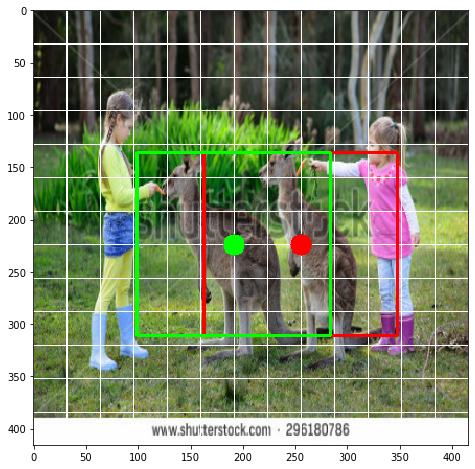

In [9]:
for x, y in train_dataset_2.take(1):
    print(i, x.shape, y.shape)
    print(y[7][8])
    print(y[7][6])
    
    img = x.numpy()
    img = np.array(img)
    true_boxes = y.numpy()
    
    # Custom (rgb) grid color and object color
    colors = [(255,0,0), (0,255,0), (0,0,255)]
    grid_color = [255, 255, 255]
    
    # Plot grid box
    # Modify the image to include the grid
    dx, dy = (32, 32) # downsamples the input by 32
    img[:,::dy,:] = grid_color
    img[::dx,:,:] = grid_color
    
    # Plot anchor box center 
    anchor_boxes_xy = [(8 * 32, 7 * 32), (6 * 32, 7 * 32)]
    for i, box_xy in enumerate(anchor_boxes_xy):
        cv2.circle(img, box_xy, 10, colors[i], -1)
    
    # Plot anchor box
    anchor_box_wh = YOLO_ANCHORS[2] * 416
    anchor_box_wh_half = anchor_box_wh / 2.
    bbox_mins = anchor_boxes_xy - anchor_box_wh_half
    bbox_maxes = anchor_boxes_xy + anchor_box_wh_half
    
    for i in range(len(bbox_mins)):
        cv2.rectangle(img, (int(bbox_mins[i][0]), int(bbox_mins[i][1])), (int(bbox_maxes[i][0]), int(bbox_maxes[i][1])), colors[i], 2)
    
    '''
    # Plot true box
    true_xy = true_boxes[..., 0:2] * 416
    ture_wh = true_boxes[..., 2:4] * 416
    true_wh_half = ture_wh / 2.
    true_mins = tf.cast(true_xy - true_wh_half, tf.int32)
    true_maxes = tf.cast(true_xy + true_wh_half, tf.int32)
    true_bbox = tf.concat((true_mins, true_maxes), axis=-1)
    
    for grid_y in true_bbox:
        for grid_x in grid_y:
            for box in grid_x:
                cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
    '''
    
    f, (ax1) = plt.subplots(1, 1, figsize=(8,8))
    f.subplots_adjust(hspace = .2, wspace = .05)
    
    ax1.imshow(img)

## Prepare the data for training

In [10]:
train_ds = train_dataset_2.shuffle(buffer_size=1024).batch(16)
train_ds

<BatchDataset shapes: ((None, 416, 416, 3), (None, 13, 13, 5, None)), types: (tf.float32, tf.float32)>

## Build the Model

![](model_data/darknet19.png)

### YOLOV2

In [11]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size=2)

def YOLOV2(num_anchors=5, num_classes=80):
    x = inputs = tf.keras.Input(shape=(416, 416, 3))
    
    # Layer 1
    x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(x)
    x = BatchNormalization(name='norm_1')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Layer 2
    x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
    x = BatchNormalization(name='norm_2')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Layer 3
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
    x = BatchNormalization(name='norm_3')(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    # Layer 4
    x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
    x = BatchNormalization(name='norm_4')(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    # Layer 5
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
    x = BatchNormalization(name='norm_5')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Layer 6
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
    x = BatchNormalization(name='norm_6')(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    # Layer 7
    x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
    x = BatchNormalization(name='norm_7')(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    # Layer 8
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
    x = BatchNormalization(name='norm_8')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Layer 9
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
    x = BatchNormalization(name='norm_9')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 10
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
    x = BatchNormalization(name='norm_10')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 11
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
    x = BatchNormalization(name='norm_11')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 12
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
    x = BatchNormalization(name='norm_12')(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    # Layer 13
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
    x = BatchNormalization(name='norm_13')(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    conv13 = x # 
    
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Layer 14
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
    x = BatchNormalization(name='norm_14')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 15
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
    x = BatchNormalization(name='norm_15')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 16
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
    x = BatchNormalization(name='norm_16')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 17
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
    x = BatchNormalization(name='norm_17')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 18 - darknet
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
    x = BatchNormalization(name='norm_18')(x)
    darknet = LeakyReLU(alpha=0.1)(x)

    ##################################################################################
    
    # Layer 19
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(darknet)
    x = BatchNormalization(name='norm_19')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 20
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
    x = BatchNormalization(name='norm_20')(x)
    conv20 = LeakyReLU(alpha=0.1)(x)
    
    # Layer 21
    conv21 = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(conv13)
    conv21 = BatchNormalization(name='norm_21')(conv21)
    conv21 = LeakyReLU(alpha=0.1)(conv21)
    conv21_reshaped = Lambda(space_to_depth_x2, name='space_to_depth')(conv21) 
    
    x = concatenate([conv21_reshaped, conv20])
    
    # Layer 22
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
    x = BatchNormalization(name='norm_22')(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    # Layer 23 - Output
    x = Conv2D(num_anchors * (num_classes + 5), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    outputs = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], 
                                              num_anchors, num_classes + 5)))(x)
        
    
    return Model(inputs, outputs)

In [12]:
model = YOLOV2(num_classes=1)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           norm_1[0][0]                     
______________________________________________________________________________________________

### Load pre-trained model

In [13]:
def load_darknet_weights(model, weights_file):
    with open(weights_file, 'rb') as wf:
        major, minor, revision, seen = np.fromfile(wf, dtype=np.int32, count=4)
        conv_idx = 0
        num_conv = 23 # 總共有23層的卷積層
        
        for i, layer in enumerate(model.layers):
            if not layer.name.startswith('conv'):
                continue
            conv_idx = int(layer.name[5:])
            
            # BatchNormalization layer
            batch_norm = None    
            if conv_idx < num_conv:
                batch_norm = model.get_layer('norm_' + str(conv_idx)) # 取得BatchNormalization層
            print("{}/{} {}".format(
                model.name, layer.name, 'bn' if batch_norm else 'bias'), end=', ')
            
            filters = layer.filters
            kerner_size = layer.kernel_size[0]
            input_dim = layer.input_shape[-1]
            
            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4*filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
            
            # darknet shape (out_dim, input_dim, height, width)
            conv_shape = (filters, input_dim, kerner_size, kerner_size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)
            
            print("Completed!")
    print("End!")

In [14]:
weights_file = './model_data/yolov2.weights'
load_darknet_weights(model, weights_file)

model/conv_1 bn, Completed!
model/conv_2 bn, Completed!
model/conv_3 bn, Completed!
model/conv_4 bn, Completed!
model/conv_5 bn, Completed!
model/conv_6 bn, Completed!
model/conv_7 bn, Completed!
model/conv_8 bn, Completed!
model/conv_9 bn, Completed!
model/conv_10 bn, Completed!
model/conv_11 bn, Completed!
model/conv_12 bn, Completed!
model/conv_13 bn, Completed!
model/conv_14 bn, Completed!
model/conv_15 bn, Completed!
model/conv_16 bn, Completed!
model/conv_17 bn, Completed!
model/conv_18 bn, Completed!
model/conv_19 bn, Completed!
model/conv_21 bn, Completed!
model/conv_20 bn, Completed!
model/conv_22 bn, Completed!
model/conv_23 bias, Completed!
End!


In [15]:
layer = model.layers[-2] # conv_23
weights = layer.get_weights()
print(weights)

[array([[[[ 1.6324505e-01,  1.1028761e-02, -8.3031710e-03, ...,
          -4.3528821e-02, -2.9398233e-02, -6.7278352e-03],
         [ 5.0851107e-01,  1.5639421e-02,  1.4129957e-02, ...,
           2.7208056e-02, -1.0999439e-02, -2.6759051e-02],
         [ 1.3652879e-01, -3.2524453e-03,  3.6156964e-02, ...,
          -1.9063070e-02, -1.5300213e-02, -2.0567816e-02],
         ...,
         [ 2.1760814e-02,  1.3657487e-02,  4.0759966e-03, ...,
          -4.8991907e-02, -3.9354715e-02,  5.3704377e-02],
         [ 1.8230497e-04,  4.2722481e-03, -6.4058485e-04, ...,
          -2.4836339e-02, -2.2992756e-02, -1.7046183e-02],
         [-1.2241791e-03, -9.2830705e-03, -6.0601713e-04, ...,
          -3.7503283e-02, -3.7547521e-02, -1.4448024e-02]]]],
      dtype=float32), array([ 0.01750153,  0.00913803, -0.14430109, -0.08590996, -2.7688012 ,
        2.4115305 ,  0.13297267,  0.8465823 , -0.07615986, -0.26251563,
       -0.22682115, -0.3024409 ,  0.00727828,  0.0496687 ,  0.03017936,
       -0.24

### Fine-tune

In [16]:
new_kernel = np.random.normal(size=weights[0].shape)/(13*13)
new_bias   = np.random.normal(size=weights[1].shape)/(13*13)
print(new_kernel)
print(new_bias)

layer.set_weights([new_kernel, new_bias]) # 重新初始化權重

[[[[-1.38937923e-03 -1.17335041e-03  8.74336183e-03 ... -6.43773832e-03
    -6.58514214e-04  5.24609668e-03]
   [-2.12806135e-04 -8.29805414e-03 -1.26924203e-05 ... -2.74413361e-03
    -5.57779056e-04  4.42036060e-03]
   [ 5.52079254e-03 -4.94617791e-03  7.23746466e-04 ...  4.58419463e-03
    -1.07559602e-02  2.19547719e-03]
   ...
   [-3.83665418e-03 -7.18800671e-03 -3.80974524e-04 ...  2.39555592e-05
    -3.69250871e-03  1.21719359e-03]
   [-1.73380338e-03  7.10813474e-03  1.03200110e-02 ... -1.55227484e-03
     1.68987287e-03 -9.26213860e-04]
   [-2.30271609e-03 -1.36105691e-03 -9.26986850e-03 ...  4.31717423e-03
     7.18467189e-04  8.76522290e-03]]]]
[ 5.23685716e-03 -1.68312086e-04  5.30581605e-03 -4.68239414e-04
 -2.18115953e-03  6.25816067e-03  3.06905686e-03  2.85797116e-03
 -5.82023737e-03  9.36279518e-03 -9.50189098e-03  7.79570009e-03
 -7.47681009e-03  1.13251326e-02  1.05648433e-02  5.97004392e-03
 -2.94052851e-03 -7.22547398e-03 -6.52039332e-03 -4.97700613e-03
  3.8471953

### YOLO LOSS

![](model_data/loss.jpg)

In [17]:
def yolo_bboxes(pred, anchors, classes):
    """ YOLO - bounding box formula
    
    bx = sigmoid(tx) + cx
    by = sigmoid(ty) + cy
    bw = pw * exp^(tw)
    bh = ph * exp^(th)
    Pr(obj) * IOU(b, object) = sigmoid(to) # confidence
    
    (tx, ty, tw, th, to) are the output of the model.
    """
    # pred: (batch_size, grid, grid, anchors, (tx, ty, tw, th, conf, ...classes))
    grid_size = tf.shape(pred)[1]
  
    box_xy = tf.sigmoid(pred[..., 0:2])
    box_wh = tf.exp(pred[..., 2:4])
    box_confidence = tf.sigmoid(pred[..., 4:5])
    box_class_probs = tf.sigmoid(pred[..., 5:])

    # box_xy: (grid_size, grid_size, num_anchors, 2)
    # grid: (grdid_siez, grid_size, 1, 2)
    #       -> [0,0],[0,1],...,[0,12],[1,0],[1,1],...,[12,12]
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
    
    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = box_wh * anchors

    return box_xy, box_wh, box_confidence, box_class_probs

In [18]:
def YoloLoss(anchors, classes=80, object_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        """"1. transform all pred outputs."""
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, conf, ...cls))
        pred_xy, pred_wh, pred_confidence, pred_class_probs = yolo_bboxes(
            y_pred, anchors, classes)

        """2. transform all true outputs."""
        # y_true: (batch_size, grid, grid, anchors, (x, y, w, h, conf, cls))
        true_xy, true_wh, true_confidence, true_class = tf.split(
            y_true, (2, 2, 1, classes), axis=-1)
        true_boxes = tf.concat([true_xy, true_wh], axis=-1)
        
        """3. true_box: remove noobject cell."""
        # true_confidence: cell has object or not
        #                 0/1 mask for detectors in [conv_height, conv_width, num_anchors, 1]
        # true_confidence_mask: [conv_height, conv_width, num_anchors]
        true_conf_mask = tf.squeeze(true_confidence, -1)
        
        """4. Calculate `coordinate loss`."""      
        xy_loss = coordinates_scale * true_conf_mask * \
                  tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = coordinates_scale * true_conf_mask * \
                  tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        
        """5. Calculate `classification loss`."""
        # square(one_hot(true_class) - pred_class_probs)
        classification_loss = class_scale * true_conf_mask * \
            tf.keras.losses.sparse_categorical_crossentropy(
                true_class, pred_class_probs)
        
        
        """6. Calculate `confidence loss.`
        
        1. Find the IOU score of each predicted box with each ground truth box.
        2. Find the Best IOU scores.
        3. A confidence detector that this cell has object if IOU > threshold otherwise no object.
        4. Calculate confidence loss.
        """
        ############################################################################################################
        # Reshape true_box: (N, grid, grid, num_anchors, 4) to (N, num_true_boxes, 4)     
        true_boxes_flat = tf.boolean_mask(true_boxes, tf.cast(true_conf_mask, tf.bool))
        
        # broadcast shape: (N, grid, grid, num_anchors, num_true_boxes, (x, y, w, h))
        true_boxes = tf.expand_dims(true_boxes, -2) # (N, 13, 13, 5, 1, 4)
        true_boxes_flat = tf.expand_dims(true_boxes_flat, 0) # (1, num_true_boxes, 4)
        new_shape = tf.broadcast_dynamic_shape(tf.shape(true_boxes), tf.shape(true_boxes_flat)) # (N, 13, 13, 5, num_true_boxes, 4)
        
        # reshape: (batch, conv_height, conv_width, num_anchors, num_true_boxes, box_params)
        true_boxes = tf.broadcast_to(true_boxes, new_shape)
        true_xy = true_boxes[..., 0:2]
        true_wh = true_boxes[..., 2:4] # (N, 13, 13, 5, num_true_boxes, 2)
        
        true_wh_half = true_wh / 2.
        true_mins = true_xy - true_wh_half
        true_maxes = true_xy + true_wh_half
        
        # Expand pred (x,y,w,h) to allow comparison with ground truth.
        # (batch, conv_height, conv_width, num_anchors, 1, box_params)
        pred_xy = tf.expand_dims(pred_xy, 4)
        pred_wh = tf.expand_dims(pred_wh, 4)
        
        pred_wh_half = pred_wh / 2.
        pred_mins = pred_xy - pred_wh_half
        pred_maxes = pred_xy + pred_wh_half
        
        intersection_mins = tf.maximum(pred_mins, true_mins)
        intersection_maxes = tf.minimum(pred_maxes, true_maxes)
        intersection_wh = tf.maximum(intersection_maxes - intersection_mins, 0.)
        intersection_areas = intersection_wh[..., 0] * intersection_wh[..., 1] # (-1, 13, 13, 5, num_true_boxes)
        
        pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
        true_areas = true_wh[..., 0] * true_wh[..., 1]
        
        """6-1. Calculate IOU scores for each location."""
        union_areas = pred_areas + true_areas - intersection_areas
        iou_scores = intersection_areas / union_areas # (-1, 13, 13, 5, num_true_boxes)
        
        """6-2. Best IOU scores."""
        best_ious = tf.reduce_max(iou_scores, axis=4)
        best_ious = tf.expand_dims(best_ious, axis=-1) #(-1, 13, 13, 5, 1)
        
        """6-3. Confidence mask (In YAD2K: object_detections)."""
        pred_conf_mask = tf.cast(best_ious > object_thresh, tf.float32) # (-1, 13, 13, 5, 1)
        
        """6-4. Confidence loss."""
        no_object_weights = (no_object_scale * (1 - pred_conf_mask) * (1 - true_confidence))
        no_objects_loss = no_object_weights * tf.square(0 - pred_confidence)
        
        objects_loss = object_scale * true_confidence * tf.square(1 - pred_confidence)
        
        confidence_loss = objects_loss + no_objects_loss
        confidence_loss = tf.reduce_sum(confidence_loss, -1)
        ############################################################################################################
       
        # 7. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss_sum = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss_sum = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        confidence_loss_sum = tf.reduce_sum(confidence_loss, axis=(1, 2, 3))
        classification_loss_sum = tf.reduce_sum(classification_loss, axis=(1, 2, 3))
        
        '''
        tf.print(xy_loss_sum)
        tf.print(wh_loss_sum)
        tf.print(confidence_loss_sum)
        tf.print(classification_loss_sum)
        '''
        
        return 0.5 * (xy_loss_sum + wh_loss_sum + confidence_loss_sum + classification_loss_sum)
    return yolo_loss

### Compile the model

In [19]:
#optimizer = tf.keras.optimizers.Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
optimizer = tf.keras.optimizers.Adam(lr=0.1e-4)
yolo_loss = YoloLoss(anchors, classes=1)

In [20]:
model.compile(optimizer=optimizer, loss=yolo_loss,
              run_eagerly=True)

## Train the model

In [ ]:
model.fit(train_ds, epochs=50) # 300

### Save and Load model

In [21]:
# Save
#tf.saved_model.save(model, path + "/model_data")
model.save(path + "/model_data/yolov2.h5") 

# Load
#model = tf.keras.models.load_model("model_data/yolov2.h5", custom_objects={'yolo_loss': yolo_loss})

## Inference

In [22]:
class_names = ['kangaroo']

### Utils

In [23]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.concat([
        box_mins[..., 0:1],  # x_min
        box_mins[..., 1:2],  # y_min
        box_maxes[..., 0:1],  # x_max
        box_maxes[..., 1:2],  # y_max  
    ], -1)

In [24]:
def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = image_shape[0]
    width = image_shape[1]
    image_dims = tf.stack([width, height, width, height])
    image_dims = tf.cast(tf.reshape(image_dims, [1, 4]), tf.float32)
    boxes = boxes * image_dims
    return boxes

In [25]:
def draw_boxes(image, out_scores, out_boxes, out_classes, class_names):
    h, w, _ = image.shape
    
    for box in out_boxes:
        left, top, right, bottom = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(h, np.floor(bottom + 0.5).astype('int32'))
        right = min(w, np.floor(right + 0.5).astype('int32'))

        # colors: RGB
        cv2.rectangle(image, (left, top), (right, bottom), (255, 0, 0), 3)
        
    return image

### YOLO head 

In [26]:
def yolo_eval(yolo_outputs, image_shape=(416, 416), max_boxes=10, score_threshold=0.6, iou_threshold=0.5):
    # Retrieve outputs of the YOLO model.
    box_xy, box_wh, box_confidence, box_class_probs = yolo_bboxes(yolo_outputs, anchors, 1)
    
    # Convert boxes to be ready for filtering functions.
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
   
    # Perform Score-filtering with a threshold of score_threshold.
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape
    boxes = scale_boxes(boxes, image_shape)
    
    # perform Non-max suppression with a threshold of iou_threshold
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

In [27]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=0.6):    
    # Compute box scores
    box_scores = box_confidence * box_class_probs
    
    # Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    box_classes = tf.argmax(box_scores, axis=-1)
    box_class_scores = tf.reduce_max(box_scores, axis=-1)
    
    # Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask = box_class_scores >= threshold
    
    # Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    print(">>>", scores.shape, boxes.shape, classes.shape, scores)
    
    return scores, boxes, classes

In [28]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes=10, iou_threshold=0.5):
    selected_indices = tf.image.non_max_suppression(
        boxes, scores, max_boxes, iou_threshold)
    
    # Use tf.gather() to select only selected_indices from scores, boxes and classes
    scores = tf.gather(scores, selected_indices)
    boxes = tf.gather(boxes, selected_indices)
    classes = tf.gather(classes, selected_indices)
    
    return scores, boxes, classes

### Start detect

./data/kangaroo/images/00054.jpg
>>> (1,) (1, 4) (1,) tf.Tensor([0.48542765], shape=(1,), dtype=float32)


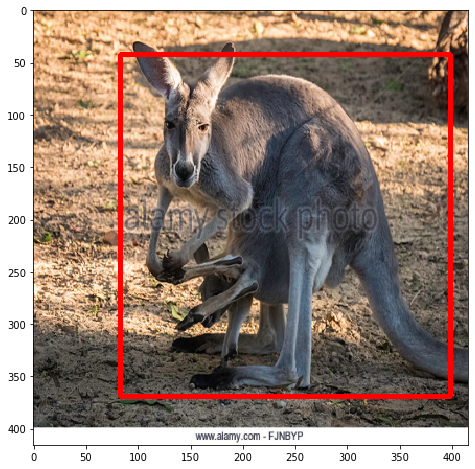

In [29]:
# 選一張圖像
img_filepath= "./data/kangaroo/images/00054.jpg"
print(img_filepath)

# 使用OpenCV讀入圖像
images = cv2.imread(img_filepath) # 載入圖像
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)

# 進行圖像輸入的前處理
input_image = cv2.resize(images, (416, 416)) # 修改輸入圖像大小來符合模型的要求
input_image = input_image / 255. # 進行圖像歸一處理
input_image = np.expand_dims(input_image, 0)  # 增加 batch dimension

# 進行圖像偵測
yolo_outputs = model.predict(input_image)

image = cv2.resize(images, (416, 416))
scores, boxes, classes = yolo_eval(yolo_outputs, score_threshold=0.3)

# Draw bounding boxes on the image file
image = draw_boxes(image, scores, boxes, classes, class_names)

# Save
cv2.imwrite("./model_data/output.jpg", image)

plt.figure(figsize=(8, 8))
plt.imshow(image)